In [18]:
# Files in data/ must be downloaded from https://doi.org/10.5281/zenodo.10932490
input_A:str = 'data/mgc_v2.9.0/mgc_graph_15_yeast.gfa'
graph_A:str = 'data/mgc_v2.9.0/mgc_graph_15_gfa1.gfa'
graph_B:str = 'data/pggb_v0.6.0/pggb_graph_15_yeast.gfa'
# Files in temp/* will be created during the execution of the notebook
edition_file: str = 'temp/yeast_edit_growing.json'
variants_file_A:str = "temp/cactus_A.vcf" # path to a vcf for graph A
variants_file_B:str = "temp/pggb_B.vcf" # path to a vcf for graph B
variants_filter_A:str = "temp/cactus.filter_A.vcf" # path to a vcf for graph A
variants_filter_B:str = "temp/pggb.filter_B.vcf" # path to a vcf for graph B
private_variants_file_A:str = 'temp/cactus.private_A.vcf'
private_variants_file_B:str = 'temp/pggb.private_A.vcf'
reference:list[str] = ['CASBJU01'] # choosing a haplotype to project on
chromosom:str = '1'

In [19]:
# Colorblind-friendly palette
colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

In [20]:
from json import load
from matplotlib import pyplot as plt
from numpy import nan
from pgGraphs import Graph
from os import system
from seaborn import regplot
from pandas import DataFrame
from scipy import stats
from itertools import pairwise
from BubbleGun.Graph import Graph as BubbleGraph
from BubbleGun.find_bubbles import find_bubbles

# Cleaning files and prepping for vg deconstruct and pancat compare

Sadly, it must be made manually.
+ If needed, convert your GFA1.1 files marked as duplicated paths with `vg convert in.gfa -W -f > out.gfa`
+ Consider reading `vg paths -Mx in.gfa` to have an understanding of haplotype naming and select the right haplotypes

In [21]:
system(f'vg convert {input_A} -W -f > {graph_A}')
system(f'vg paths -Mx {graph_A}')

#NAME	SENSE	SAMPLE	HAPLOTYPE	LOCUS	PHASE_BLOCK	SUBRANGE
CASBJU01#0#CASBJU01	REFERENCE	CASBJU01	0	CASBJU01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJM01#0#CASBJM01#0	HAPLOTYPE	CASBJM01	0	CASBJM01	0	NO_SUBRANGE
CASBJL01#0#CASBJL01#0	HAPLOTYPE	CASBJL01	0	CASBJL01	0	NO_SUBRANGE
CASBJG01#0#CASBJG01#0	HAPLOTYPE	CASBJG01	0	CASBJG01	0	NO_SUBRANGE
CASBJI01#0#CASBJI01#0	HAPLOTYPE	CASBJI01	0	CASBJI01	0	NO_SUBRANGE
CASBJJ01#0#CASBJJ01#0	HAPLOTYPE	CASBJJ01	0	CASBJJ01	0	NO_SUBRANGE
CASBJS01#0#CASBJS01#0	HAPLOTYPE	CASBJS01	0	CASBJS01	0	NO_SUBRANGE
CASBJN01#0#CASBJN01#0	HAPLOTYPE	CASBJN01	0	CASBJN01	0	NO_SUBRANGE
CASBIZ01#0#CASBIZ01#0	HAPLOTYPE	CASBIZ01	0	CASBIZ01	0	NO_SUBRANGE
CASBIT01#0#CASBIT01#0	HAPLOTYPE	CASBIT01	0	CASBIT01	0	NO_SUBRANGE
CASBJT01#0#CASBJT01#0	HAPLOTYPE	CASBJT01	0	CASBJT01	0	NO_SUBRANGE
CASBJV01#0#CASBJV01#0	HAPLOTYPE	CASBJV01	0	CASBJV01	0	NO_SUBRANGE
CASBJQ01#0#CASBJQ01#0	HAPLOTYPE	CASBJQ01	0	CASBJQ01	0	NO_SUBRANGE
CASBIW01#0#CASBIW01#0	HAPLOTYPE	CASBIW01	0	CASBIW01	0	NO_SUBRANGE
CASBJH01#

0

In [22]:
system(f'vg paths -Mx {graph_B}')

#NAME	SENSE	SAMPLE	HAPLOTYPE	LOCUS	PHASE_BLOCK	SUBRANGE
CASBJS01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJS01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJG01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJG01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJI01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJI01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBIT01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBIT01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJU01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJU01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJH01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJH01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJQ01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJQ01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJN01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJN01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJT01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJT01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJM01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJM01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBJL01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBJL01	NO_PHASE_BLOCK	NO_SUBRANGE
CASBIZ01	GENERIC	NO_SAMPLE_NAME	NO_HAPLOTYPE	CASBIZ01

0

In [23]:
# Setting haplotypes names used for comparison and variant calling
path_ref_A:str = f'{reference[0]}#0#{reference[0]}'
path_ref_B:str = f'{reference[0]}'

In [24]:
# First, we compute edition to be sure to have a list of breakpoints
system(f'pancat compare {graph_A} {graph_B} -o {edition_file}')

# Count the number of lines in the variants files
num_lines_A = int(system(f"grep -v '^#' {variants_file_A} | wc -l"))
num_lines_B = int(system(f"grep -v '^#' {variants_file_B} | wc -l"))

# Then, we compute variants file
system(f'vg deconstruct -e -a -p "{path_ref_A}" {graph_A} > {variants_file_A}') # format for raw cactus files > "seq000#{reference[0]}"
system(f'vg deconstruct -e -a -p "{path_ref_B}" {graph_B} > {variants_file_B}') # format for raw pggb files > "seq000"

[10/03/2024 04:06:12 PM] Loaded graph data/mgc_v2.9.0/mgc_graph_15_gfa1.gfa in memory
Paths of Graph_A CASBIT01#0#CASBIT01#0, CASBIW01#0#CASBIW01#0, CASBIZ01#0#CASBIZ01#0, CASBJG01#0#CASBJG01#0, CASBJH01#0#CASBJH01#0, CASBJI01#0#CASBJI01#0, CASBJJ01#0#CASBJJ01#0, CASBJL01#0#CASBJL01#0, CASBJM01#0#CASBJM01#0, CASBJN01#0#CASBJN01#0, CASBJQ01#0#CASBJQ01#0, CASBJS01#0#CASBJS01#0, CASBJT01#0#CASBJT01#0, CASBJU01, CASBJV01#0#CASBJV01#0
[10/03/2024 04:06:13 PM] Loaded graph data/pggb_v0.6.0/pggb_graph_15_yeast.gfa in memory
Paths of Graph_B CASBJU01, CASBJM01, CASBJG01, CASBJL01, CASBIZ01, CASBIT01, CASBIW01, CASBJJ01, CASBJN01, CASBJI01, CASBJQ01, CASBJV01, CASBJS01, CASBJH01, CASBJT01
[10/03/2024 04:06:13 PM] Computing edition for graphs on single thread
PATH SELECTION: {'CASBJU01'}
[10/03/2024 04:06:13 PM] Saving results in temp/yeast_edit_growing.json
[10/03/2024 04:06:13 PM] Job terminated sucessfully!
func:'perform_edition' args:[(), {'gfa_A': 'data/mgc_v2.9.0/mgc_graph_15_gfa1.gfa', 'g

0

In [25]:
editions:dict[str,list] = load(open(edition_file,'r',encoding='utf-8'))

# Loading graphs
cactus_gfa:Graph = Graph(graph_A)
pggb_gfa:Graph = Graph(graph_B)

In [26]:
# Displaying path names
cactus_gfa.paths.keys()

dict_keys(['CASBIT01#0#CASBIT01#0', 'CASBIW01#0#CASBIW01#0', 'CASBIZ01#0#CASBIZ01#0', 'CASBJG01#0#CASBJG01#0', 'CASBJH01#0#CASBJH01#0', 'CASBJI01#0#CASBJI01#0', 'CASBJJ01#0#CASBJJ01#0', 'CASBJL01#0#CASBJL01#0', 'CASBJM01#0#CASBJM01#0', 'CASBJN01#0#CASBJN01#0', 'CASBJQ01#0#CASBJQ01#0', 'CASBJS01#0#CASBJS01#0', 'CASBJT01#0#CASBJT01#0', 'CASBJU01', 'CASBJV01#0#CASBJV01#0'])

In [27]:
find_bubbles(bgraph_A := BubbleGraph(graph_A))
find_bubbles(bgraph_B := BubbleGraph(graph_B))

In [29]:
# Computing statistics for the graphs
print("----- CACTUS -----")
print(f"{len(cactus_gfa.segments)} segments in cactus")
print(f"{len(cactus_gfa.lines)} edges in cactus")
print(f"{len(cactus_gfa.paths)} paths in cactus")
print(f"{sum([len(s['seq']) for s in cactus_gfa.segments.values()])} bases in cactus")
print(f"{len(bgraph_A.bubbles)} bubbles in cactus")
print("----- PGGB -----")
print(f"{len(pggb_gfa.segments)} segments in pggb")
print(f"{len(pggb_gfa.lines)} edges in pggb")
print(f"{len(pggb_gfa.paths)} paths in pggb")
print(f"{sum([len(s['seq']) for s in pggb_gfa.segments.values()])} bases in pggb")
print(f"{len(bgraph_B.bubbles)} bubbles in pggb")
print("----- EDITION -----")
print(editions.keys())
print(f"Number of splits: {len(editions['splits'])}")
print(f"Number of merges: {len(editions['merges'])}")

----- CACTUS -----
34889 segments in cactus
48130 edges in cactus
15 paths in cactus
386083 bases in cactus
10915 bubbles in cactus
----- PGGB -----
27213 segments in pggb
37755 edges in pggb
15 paths in pggb
350140 bases in pggb
8626 bubbles in pggb
----- EDITION -----
dict_keys(['CASBJU01'])


KeyError: 'splits'

# Performing comparison

First, we will look at the distribution of variants along the graph.
- We need to get the length of the reference sequence for the x-axis of the graph
- Then, we can plot by position the variants from the according vcfs

In [12]:
# We can take any of the two as they have the same content in sequences
reference_length:int = sum([cactus_gfa.segments[x]['length'] for x,_ in cactus_gfa.paths[reference[0].upper()]['path']])
print(f'Length of the reference is {reference_length} bp.')

Length of the reference is 222424 bp.


We open the variants files

In [13]:
file_A_variants:dict[str,tuple] = dict()
with open(variants_file_A,'r') as vcf_A:
    for line in vcf_A:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_A_variants[l[1]]=(l[3],l[4])
            
file_B_variants:dict[str,tuple] = dict()
with open(variants_file_B,'r') as vcf_B:
    for line in vcf_B:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_B_variants[l[1]]=(l[3],l[4])

We split the variants in batches (percentage of the sequence)

In [14]:
sampling:int = 200

# Comptage des variants dans chacun des graphes (variants totaux)
counts_A:list[int] = [0 for _ in range(sampling)]
counts_B:list[int] = [0 for _ in range(sampling)]
counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
counts_B_sup_50:list[int] = [0 for _ in range(sampling)]

# Comptage des variants privés
p_counts_A:list[int] = [0 for _ in range(sampling)]
p_counts_B:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_50:list[int] = [0 for _ in range(sampling)]


ratios:float = sampling/reference_length


for pos in file_A_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_A[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_A[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_2[int(int(pos)*ratios)] += 1

for pos in file_B_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_B[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_B[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_2[int(int(pos)*ratios)] += 1

# print(f"Percentage of variants of size 1: (A) {sum([counts_A[i]-counts_A_sup_2[i] for i in range(sampling)])/sum(counts_A)} (B) {sum([counts_B[i]-counts_B_sup_2[i] for i in range(sampling)])/sum(counts_B)}")

We plot variations along the reference

Then, we compute editions along the reference. We can only display editions on reference, sadly.

In [15]:
sampling:int = 200
counts_editions:list[int] = [0 for _ in range(sampling)]

counts_merges:list[int] = [0 for _ in range(sampling)]
counts_splits:list[int] = [0 for _ in range(sampling)]
ratios:float = sampling/reference_length

for merge in editions[reference[0].upper()]['merges']:
    counts_editions[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_editions[int(int(split[0])*ratios)] += 1
    
for merge in editions[reference[0].upper()]['merges']:
    counts_merges[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_splits[int(int(split[0])*ratios)] += 1

In [16]:
counts_nodes_cactus:list[int] = [0 for _ in range(sampling)]
counts_nodes_pggb:list[int] = [0 for _ in range(sampling)]

pos_counter: int = 0
for x,_ in cactus_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_cactus[int(float(pos_counter)*ratios)] +=1
    pos_counter += cactus_gfa.segments[x]['length']
    
pos_counter: int = 0
for x,_ in pggb_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_pggb[int(float(pos_counter)*ratios)] +=1
    pos_counter += pggb_gfa.segments[x]['length']

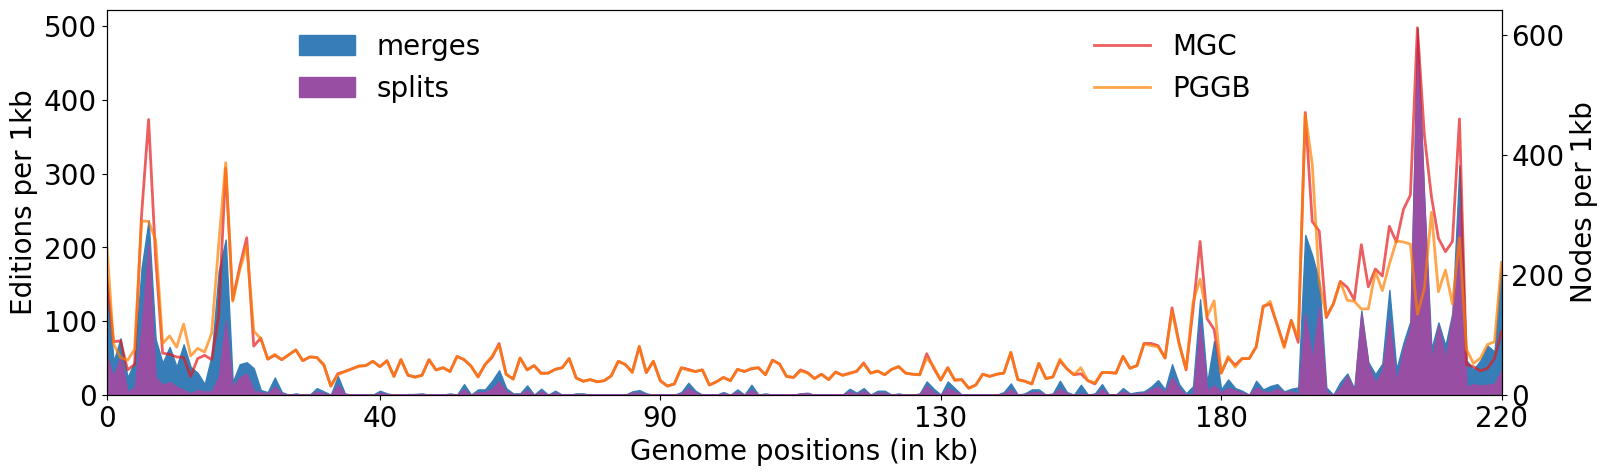

Number of splits: 3743
Number of merges: 2555


<Figure size 640x480 with 0 Axes>

In [17]:
from matplotlib import rc
font = {'size': 20}
rc('font', **font)
kb:int = 1000
fig, ax = plt.subplots(figsize=(18,5))
#fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")
#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')
ax.fill_between(list(range(sampling)),[ce/(reference_length/sampling)*kb for ce in counts_editions], color=colors['blue'], label='merges')
ax.fill_between(list(range(sampling)),[cs/(reference_length/sampling)*kb for cs in counts_splits], color=colors['purple'], label='splits')
ax.set_ylabel(f'Editions per 1kb')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.set_xlabel(f'Genome positions (in kb)')
ax.legend(loc=(.13,.73),frameon=False)
ax.set_xlim(left=0,right=sampling-1)
ax.set_ylim(bottom=0)
axb = ax.twinx()
axb.set_ylabel(f'Nodes per 1kb')
axb.set_xticks([0]+[__-1 for __ in range(1,sampling+2) if not __%40])
axb.set_xticklabels(['0']+[int(round(__/ratios,-4)/1000) for __ in range(1,sampling+2) if not __%40])
axb.plot([nc/(reference_length/sampling)*kb for nc in counts_nodes_cactus],color=colors['red'], label='MGC',linewidth=2, alpha=.7) # ,linestyle='dashed'
axb.plot([np/(reference_length/sampling)*kb for np in counts_nodes_pggb],color=colors['orange'], label='PGGB',linewidth=2, alpha=.7)
axb.legend(loc=(.7,.73),frameon=False)
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0)
plt.savefig("figures/editions_nodes_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

print(f"Number of splits: {sum(counts_splits)}")
print(f"Number of merges: {sum(counts_merges)}")

In [84]:
lengths_A:list[int] = [0 for _ in range(sampling)]
lengths_B:list[int] = [0 for _ in range(sampling)]

for pos in file_A_variants.keys():
    lengths_A[int(int(pos)*ratios)] += max([len(x) for x in file_A_variants[pos][1].split(',')])/len(file_A_variants[pos][1].split(','))

for pos in file_B_variants.keys():
    lengths_B[int(int(pos)*ratios)] += max([len(x) for x in file_B_variants[pos][1].split(',')])/len(file_B_variants[pos][1].split(','))

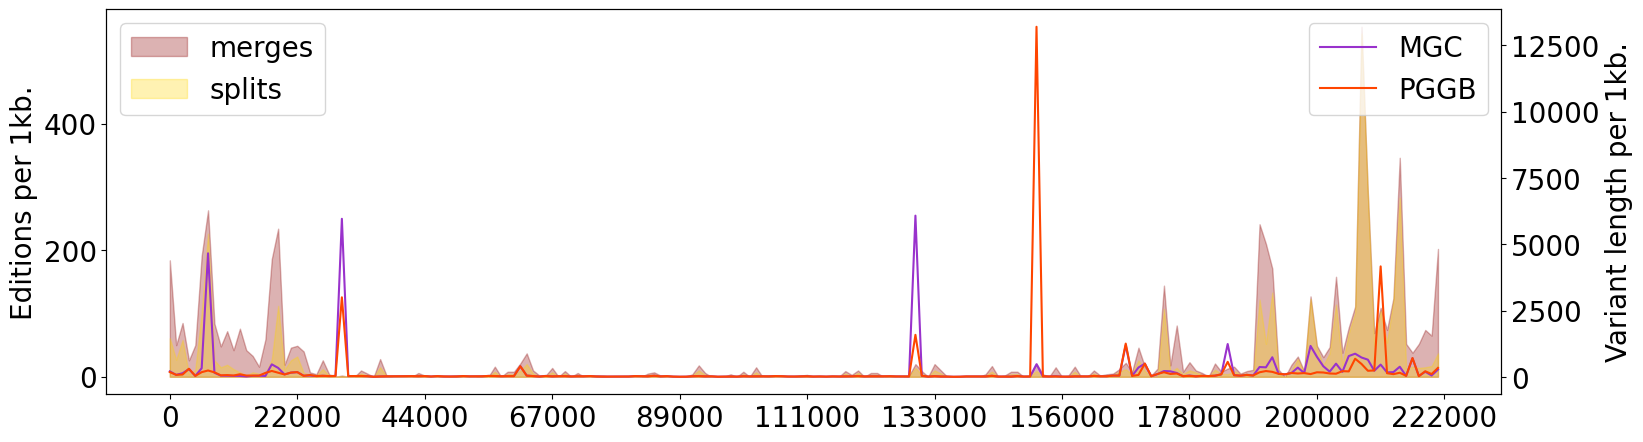

<Figure size 640x480 with 0 Axes>

In [85]:
fig, ax = plt.subplots(figsize=(18,5))
#fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax.fill_between(list(range(sampling)),counts_editions, color= "darkred", label='merges',alpha=.3)
ax.fill_between(list(range(sampling)),counts_splits, color= "gold", label='splits',alpha=.3)
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')



axb = ax.twinx()
axb.set_ylabel(f'Variant length per {round((reference_length/200)/1000)}kb.')
axb.set_xticks([__ for __ in range(sampling+1) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])


axb.plot(lengths_A,color='darkorchid', label='MGC') # ,linestyle='dashed'
axb.plot(lengths_B,color='orangered', label='PGGB') # ,linestyle='dashed'
axb.legend(loc='upper right')

plt.savefig("figures/editions_nodes_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

In [86]:
def get_gc_percentage(sequence:str) -> float:
    return (sum([1 for x in sequence if x=='G' or x=='C'])/len(sequence))*100

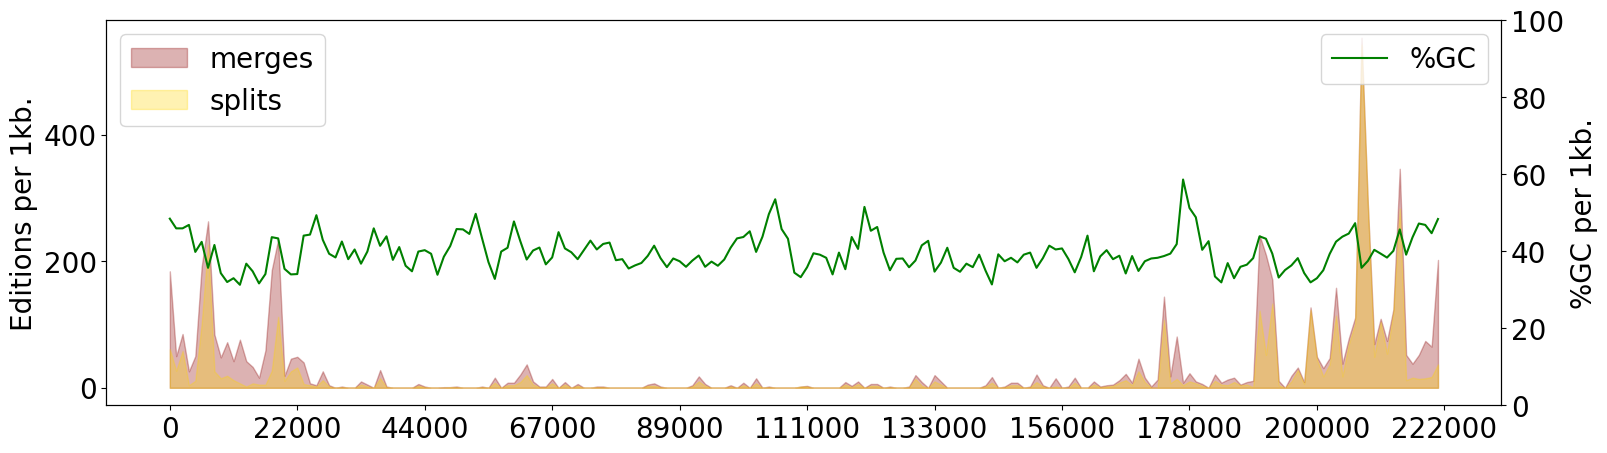

<Figure size 640x480 with 0 Axes>

In [87]:
fig, ax = plt.subplots(figsize=(18,5))
#fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax.fill_between(list(range(sampling)),counts_editions, color= "darkred", label='merges',alpha=.3)
ax.fill_between(list(range(sampling)),counts_splits, color= "gold", label='splits',alpha=.3)
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')

seq:str = ''.join(cactus_gfa.reconstruct_sequences()[reference[0]])
seq_bins:list = [get_gc_percentage(seq[int(x*(reference_length/200)):int((x+1)*(reference_length/200))]) for x in range(sampling)]

axb = ax.twinx()
axb.set_ylabel(f'%GC per {round((reference_length/200)/1000)}kb.')
axb.set_xticks([__ for __ in range(sampling+1) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])
axb.set_ylim((0,100))

axb.plot(seq_bins,color='green', label=f'%GC') # ,linestyle='dashed'
axb.legend(loc='upper right')

plt.savefig("figures/editions_nodes_along_reference.png", bbox_inches='tight')
plt.show()
plt.clf()

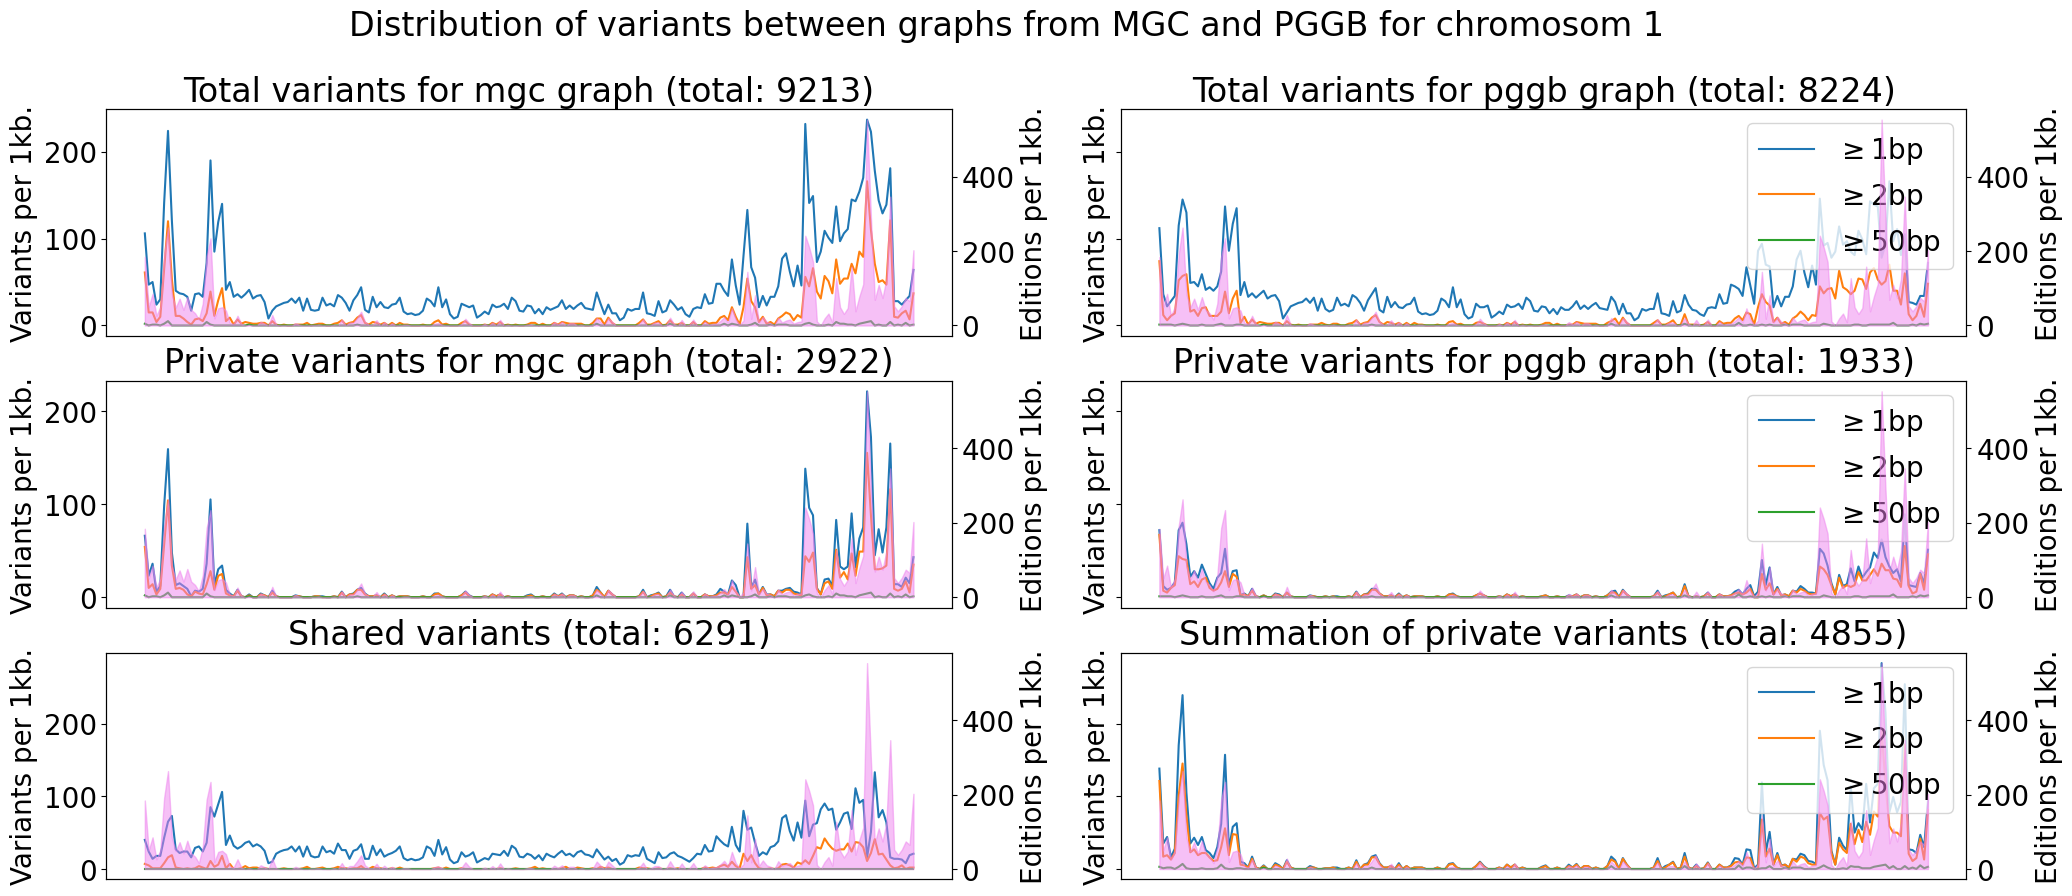

<Figure size 640x480 with 0 Axes>

In [88]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(24,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A)
ax1.plot(counts_A_sup_2)
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B, label='$\geq$1bp')
ax2.plot(counts_B_sup_2, label='$\geq$2bp')
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A)
ax3.plot(p_counts_A_sup_2)
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B, label='$\geq$1bp')
ax4.plot(p_counts_B_sup_2, label='$\geq$2bp')
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)])
ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)])
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp')
ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

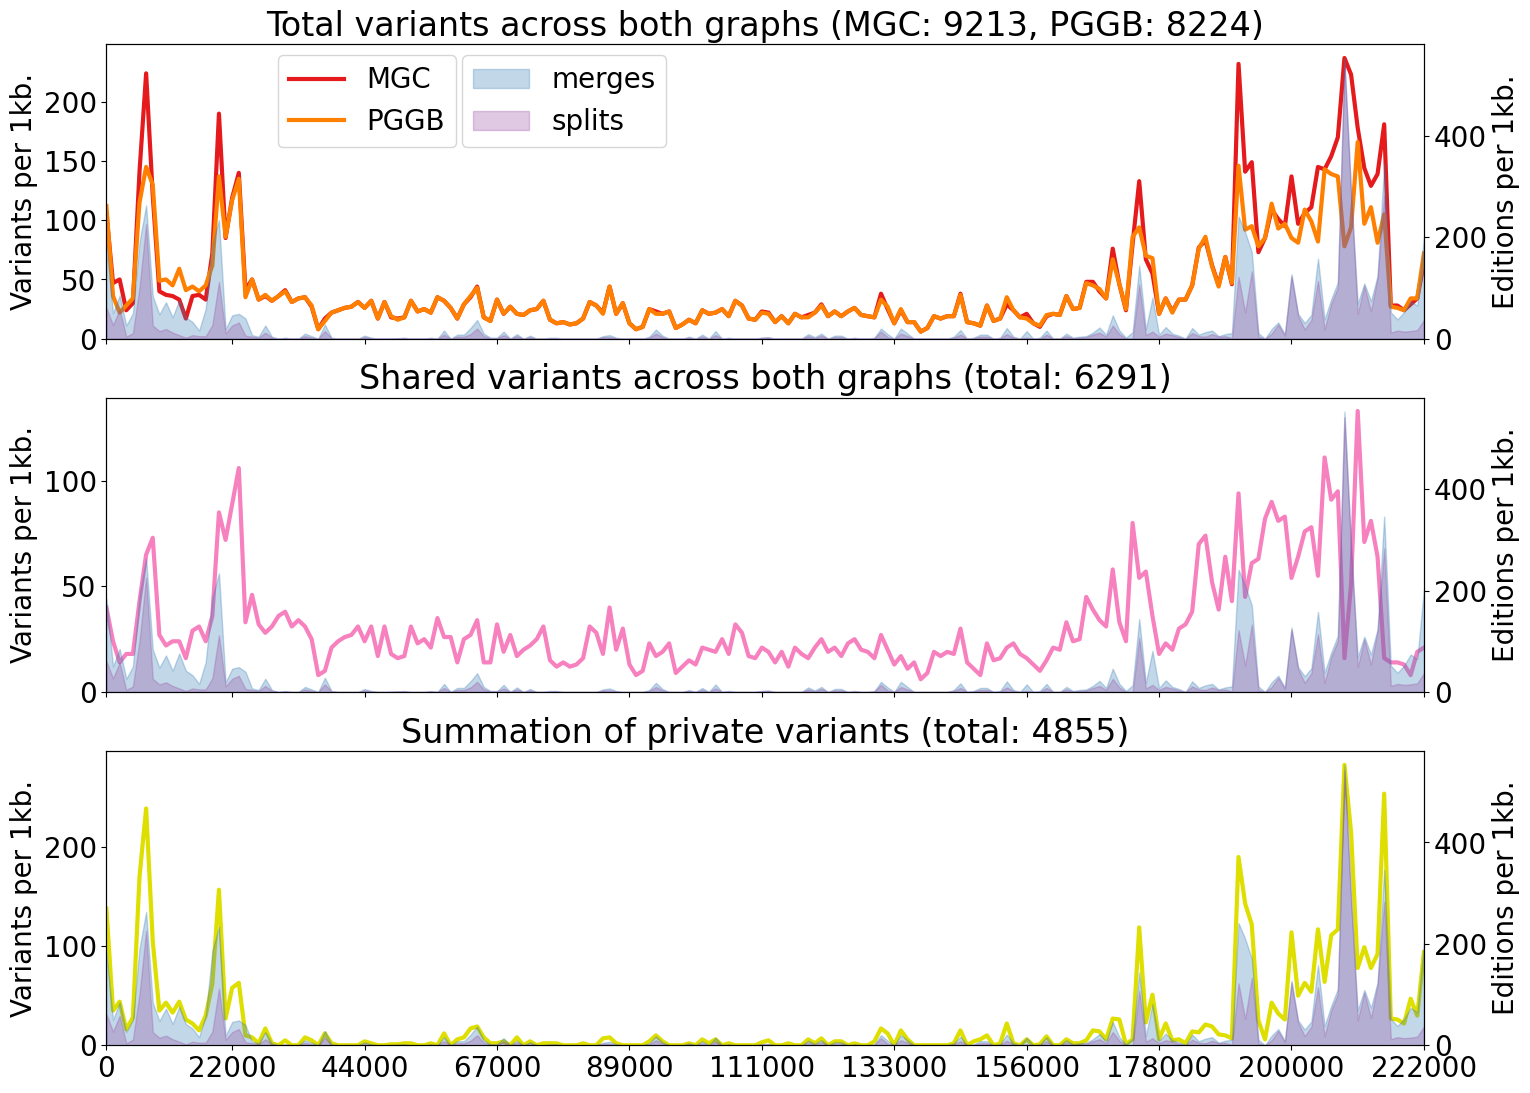

<Figure size 640x480 with 0 Axes>

In [89]:
fig, (ax2, ax5, ax6) = plt.subplots(3,1, sharex=True, sharey='row', figsize=(17,13))

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.3

for axs in (ax2, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color=colors['blue'], label='merges',alpha=alpha)
    __.fill_between(list(range(sampling)),counts_splits, color=colors['purple'], label='splits',alpha=alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')
    axs.set_xlim(left=0,right=sampling-1)
    __.set_ylim(0)
    if axs == ax2:
        __.legend(loc=(.27,.65))

ax2.set_title(f"Total variants across both graphs (MGC: {sum(counts_A)}, PGGB: {sum(counts_B)})")
ax2.plot(counts_A, label='MGC', color=colors['red'], linewidth=3)
ax2.plot(counts_B, label='PGGB', color=colors['orange'], linewidth=3)
ax2.set_xlim(left=0,right=sampling-1)
ax2.set_ylim(bottom=0)
ax2.legend(loc=(.13,.65))

ax5.set_title(f"Shared variants across both graphs (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)], label='$\geq$1bp', color=colors['pink'], linewidth=3)
#ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)], label='$\geq$50bp')
ax5.set_xlim(left=0,right=sampling-1)
ax5.set_ylim(bottom=0)
#ax5.legend(loc='upper right')

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp', color=colors['yellow'], linewidth=3)
#ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')
ax6.set_xticks([__-1 if __!=0 else 0 for __ in range(sampling+2) if not __%20])
ax6.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+2) if not __%20 ])
ax6.set_xlim(left=0,right=sampling-1)
ax6.set_ylim(bottom=0)
#ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile_supp.png", bbox_inches='tight')
plt.show()
plt.clf()

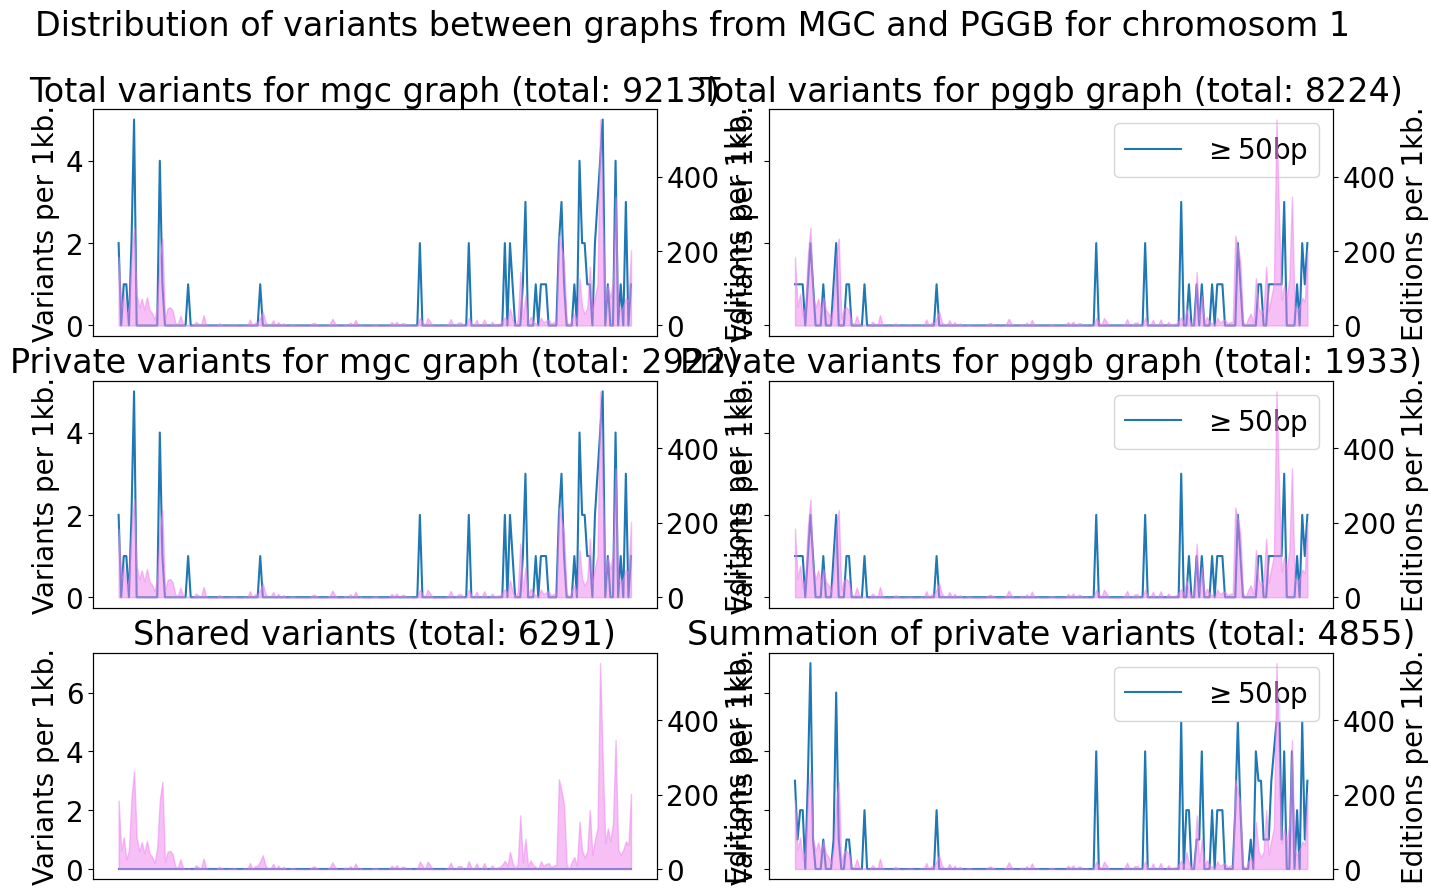

<Figure size 640x480 with 0 Axes>

In [90]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(16,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("figures/baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

We build a dataframe

In [91]:
df_ve:DataFrame = DataFrame(
    data={
        'edition_count':counts_editions,
        'full_total':[(counts_A[i]+counts_B[i])/2 for i in range(sampling)],
        'total_variants_mgc':counts_A,
        'total_variants_mgc_sup_2':counts_A_sup_2,
        'total_variants_mgc_sup_50':counts_A_sup_50,
        'private_variants_mgc':p_counts_A,
        'private_variants_mgc_sup_2':p_counts_A_sup_2,
        'private_variants_mgc_sup_50':p_counts_A_sup_50,
        'total_variants_pggb':counts_B,
        'total_variants_pggb_sup_2':counts_B_sup_2,
        'total_variants_pggb_sup_50':counts_B_sup_50,
        'private_variants_pggb':p_counts_B,
        'private_variants_pggb_sup_2':p_counts_B_sup_2,
        'private_variants_pggb_sup_50':p_counts_B_sup_50,
        'shared_variants':[counts_A[i] - p_counts_A[i] for i in range(sampling)],
        'shared_variants_sup_2':[counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)],
        'shared_variants_sup_50':[counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)],
        'private_variants_sum':[p_counts_A[i]+ p_counts_B[i] for i in range(sampling)],
        'private_variants_sum_sup_2':[p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)],
        'private_variants_sum_sup_50':[p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)],
        'mgc_nodes':counts_nodes_cactus,
        'pggb_nodes':counts_nodes_pggb,
        'average_nodes':[(counts_nodes_cactus[i]+counts_nodes_pggb[i])/2 for i in range(sampling)]
    }
)

Then we build correlograms

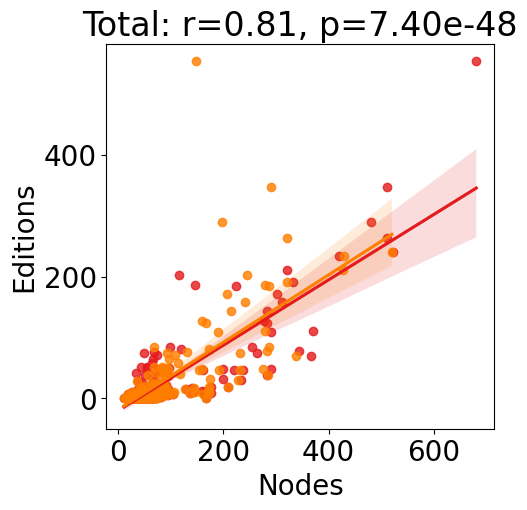

In [92]:
fig, ax = plt.subplots(figsize=(5,5))


ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[1]:.2e}")
regplot(x='mgc_nodes', y='edition_count', data=df_ve, ax=ax, color=cb_colors['red'])
regplot(x='pggb_nodes', y='edition_count', data=df_ve, ax=ax, color=cb_colors['orange'])
ax.set_ylabel('Editions')
ax.set_xlabel('Nodes')

plt.savefig("figures/correlograms_nodes.png", bbox_inches='tight')

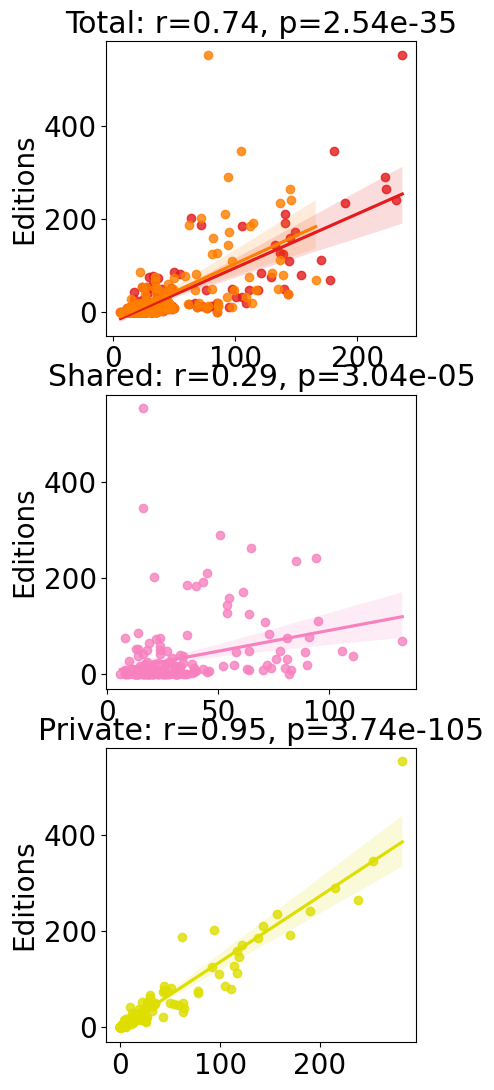

In [93]:
fig, (ax2, ax3, ax4) = plt.subplots(3,1, figsize=(4,13))
#fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")
# Setting font parameters
plt.rcParams.update({'font.size': 18})

ax2.set_title(f"Total: r={round(stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[1]:.2e}")
regplot(x='total_variants_mgc', y='edition_count', data=df_ve, ax=ax2, color=cb_colors['red'])
regplot(x='total_variants_pggb', y='edition_count', data=df_ve, ax=ax2, color=cb_colors['orange'])
ax2.set_ylabel('Editions')
ax2.set_xlabel('')

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3, color=cb_colors['pink'])
#regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
#regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)
ax3.set_ylabel('Editions')
ax3.set_xlabel('')

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4, color=cb_colors['yellow'])
#regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
#regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)
ax4.set_ylabel('Editions')
ax4.set_xlabel('')

plt.savefig("figures/correlograms_editions.png", bbox_inches='tight')

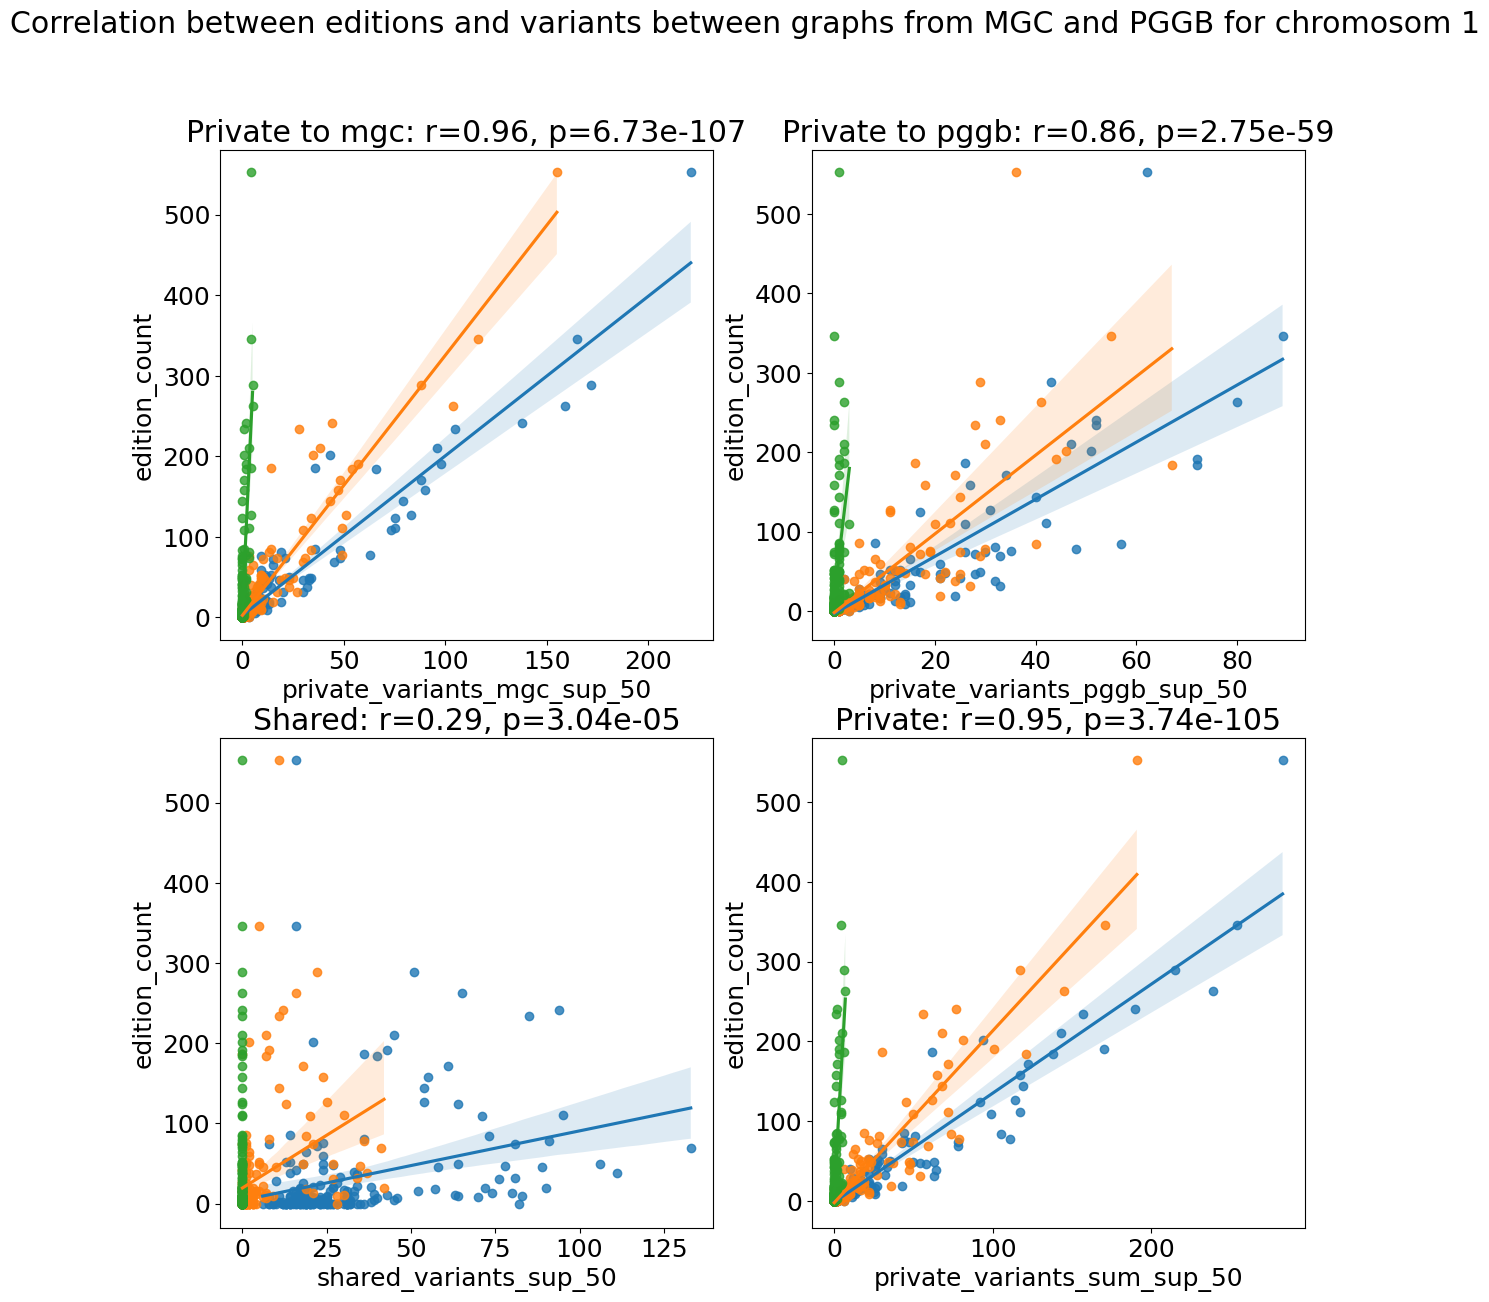

In [94]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,14))
fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")


ax1.set_title(f"Private to mgc: r={round(stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_mgc', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_2', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_50', y='edition_count', data=df_ve, ax=ax1)

ax2.set_title(f"Private to pggb: r={round(stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_pggb', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_2', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_50', y='edition_count', data=df_ve, ax=ax2)

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)

plt.savefig("figures/correlograms_variants_classes.png", bbox_inches='tight')

In [95]:
sampling:int = 200

# Comptage des variants dans chacun des graphes (variants totaux)
counts_A_substitutions:list[int] = [0 for _ in range(sampling)]
counts_B_substitutions:list[int] = [0 for _ in range(sampling)]
counts_A_private_substitution:list[int] = [0 for _ in range(sampling)]
counts_B_private_substitution:list[int] = [0 for _ in range(sampling)]

shared_others:list[int] = [0 for _ in range(sampling)]
shared_size_1:list[int] = [0 for _ in range(sampling)]
shared_size_2_9:list[int] = [0 for _ in range(sampling)]
shared_size_10_49:list[int] = [0 for _ in range(sampling)]
shared_size_50:list[int] = [0 for _ in range(sampling)]

ratios:float = sampling/reference_length

with open(private_variants_file_A,'w',encoding='utf-8') as pwriter_A:
    with open(variants_file_A,'r',encoding='utf-8') as reader_A:
        all_lines:list[str] = reader_A.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_A.write(line)
        for pos in file_A_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_A_variants[pos][0]) for x in file_A_variants[pos][1].split(',')]):
                counts_A_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_A_private_substitution[int(int(pos)*ratios)] += 1
            if is_common_variant:
                if all([len(x) == 1 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_1[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 2 and len(x) < 10 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_2_9[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 10 and len(x) < 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_10_49[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_50[int(int(pos)*ratios)] += 1
                else:
                    # We have a variant with multiple sizes
                    shared_others[int(int(pos)*ratios)] += 1
            else:
                for line in all_lines:
                    if not line.startswith('#'):
                        l:list[str] = line.split()
                        if pos == l[1] and file_A_variants[pos] == (l[3],l[4]):
                            pwriter_A.write(line)
                    
with open(private_variants_file_B,'w',encoding='utf-8') as pwriter_B:
    with open(variants_file_B,'r',encoding='utf-8') as reader_B:
        all_lines:list[str] = reader_B.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_B.write(line)
        for pos in file_B_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_B_variants[pos][0]) for x in file_B_variants[pos][1].split(',')]):
                counts_B_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_B_private_substitution[int(int(pos)*ratios)] += 1
                    for line in all_lines:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            if pos == l[1] and file_B_variants[pos] == (l[3],l[4]):
                                pwriter_B.write(line)

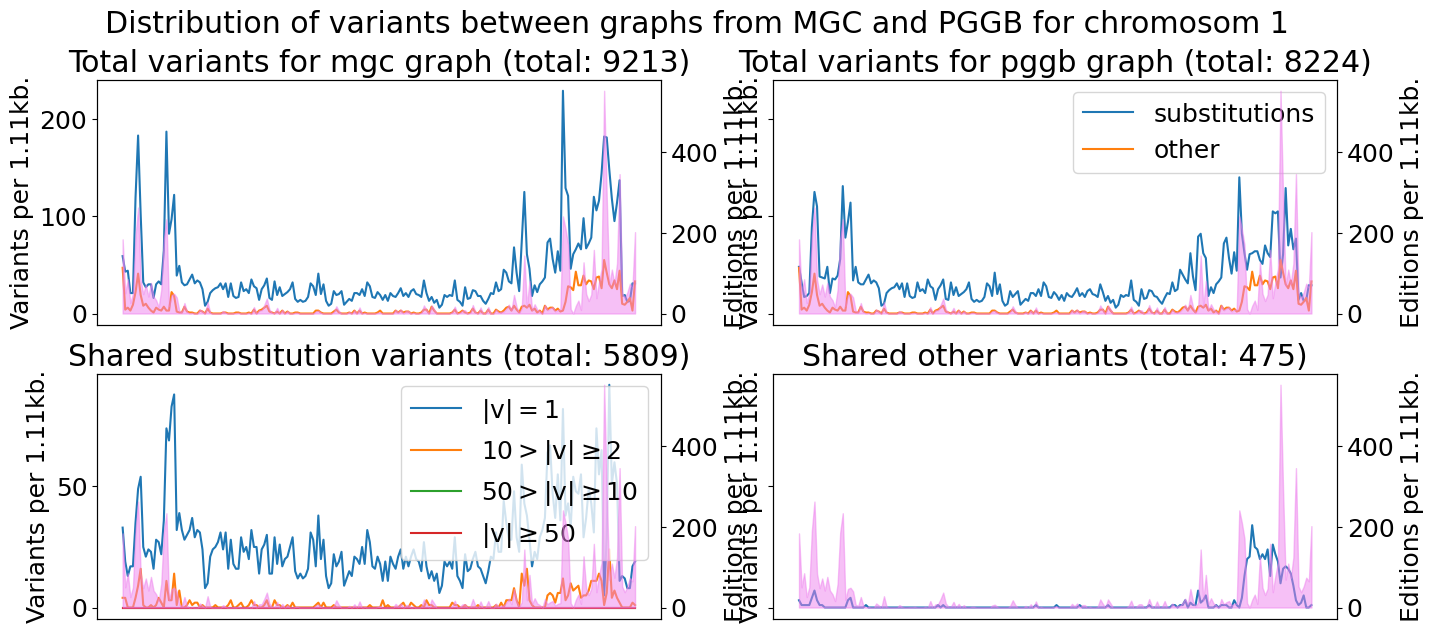

<Figure size 640x480 with 0 Axes>

In [96]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey='row', figsize=(16,7))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000,2)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000,2)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_substitutions)
ax1.plot([counts_A[i] - counts_A_substitutions[i] for i in range(sampling)])


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_substitutions, label='substitutions')
ax2.plot([counts_A[i]- counts_A_substitutions[i] for i in range(sampling)], label='other')

ax2.legend(loc='upper right')

# STABLE VARIANTS (shared variants across both graphs)

ax3.set_title(f"Shared substitution variants (total: {sum([counts_A_substitutions[i]- counts_A_private_substitution[i] for i in range(sampling)])})")
ax3.plot(shared_size_1, label='|v|$=$1')
ax3.plot(shared_size_2_9, label='10$>$|v|$\geq$2')
ax3.plot(shared_size_10_49, label='50$>$|v|$\geq$10')
ax3.plot(shared_size_50, label='|v|$\geq$50')

ax3.legend(loc='upper right')

ax4.set_title(f"Shared other variants (total: {sum(shared_others)})")
ax4.plot(shared_others, label='others')

plt.savefig("figures/variants_distribution_types.png", bbox_inches='tight')
plt.show()
plt.clf()